# Representação de cor

https://software.intel.com/en-us/ipp-dev-reference-color-models
https://docs.opencv.org/3.1.0/de/d25/imgproc_color_conversions.html

### RGB (vermelho, verde, azul)
<img src="images/teoria/cubo_RGB.jpg" width=800>

### HSV (matiz, saturação, intensidade)
Permite representar a cor em uma dimensão (matiz):
<img src="images/teoria/matiz.png" width=400>
<img src="images/teoria/solido_HSV.jpg" width=800>

### LUV (intensidade, componente de cor U, componente de cor V)
Representa a cor em duas dimensões.

“Perceptually uniform” means that two colors that are equally distant in the color space are equally distant perceptually. 

<img src="images/teoria/diagrama_LUV.jpg" width=800>
<img src="images/teoria/RGB_no_LUV.jpg" width=800>

In [4]:
# Representações de cores
import cv2
from matplotlib import pyplot as plt
import numpy as np

# img_BGR = cv2.imread('images/flowers-left.png')
# img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
# plt.imshow(img_RGB); plt.show()

# img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
# plt.imshow(img_HSV[:,:,0], cmap='hsv'); plt.colorbar(); plt.title('HSV: matiz'); plt.show()
# plt.imshow(img_HSV[:,:,1]); plt.colorbar(); plt.title('HSV: saturação'); plt.show()
# plt.imshow(img_HSV[:,:,2]); plt.colorbar(); plt.title('HSV: intensidade'); plt.show()
# # Obs.: o colormap default é 'viridis', pois permite diferenciar bem os valores altos dos valores baixos.
# # Além disso, o caso mais comum de deficiência na percepção de cor é diferenciar o vermelho do verde.
# # https://matplotlib.org/users/colormaps.html

# # Note a matiz arbitrária em pontos de baixa saturação.

# img_LUV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2LUV)
# plt.imshow(img_LUV[:,:,0]); plt.colorbar(); plt.title('LUV: L (intensidade)'); plt.show()
# plt.imshow(img_LUV[:,:,1]); plt.colorbar(); plt.title('LUV: canal U'); plt.show()
# plt.imshow(img_LUV[:,:,2]); plt.colorbar(); plt.title('LUV: canal V'); plt.show()
# # Obs.: alto no U: vermelho, alto no V e baixo no U: verde, baixo no V: azul
# # Ver figura images/teoria/diagrama_LUV.jpg

## Watershed

#### Theory [OpenCV]

Any grayscale image can be __viewed as a topographic surface__ where high intensity denotes peaks and hills while low intensity denotes valleys. You __start filling every isolated valleys (local minima) with different colored water (labels)__. As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors will start to merge. To avoid that, you __build barriers in the locations where water merges__. You continue the work of filling water and building barriers __until all the peaks are under water__. Then the barriers you created gives you the segmentation result. This is the "philosophy" behind the watershed. You can visit the CMM webpage on watershed to understand it with the help of some animations.

http://cmm.ensmp.fr/~beucher/wtshed.html
<img src="images/teoria/watershed_superficie_topografica_1.gif" width=400>
<img src="images/teoria/watershed_superficie_topografica_2.gif" width=400>

##### Controlado por marcação
But this approach gives you __oversegmented result due to noise or any other irregularities__ in the image. So OpenCV implemented a marker-based watershed algorithm where you __specify which are all valley points__ are to be merged and which are not. It is an interactive image segmentation. What we do is to give different labels for our object we know. Label the region which we are sure of being the foreground or object with one color (or intensity), label the region which we are sure of being background or non-object with another color and finally the region which we are not sure of anything, label it with 0. That is our marker. Then apply watershed algorithm. Then our marker will be updated with the labels we gave, and the boundaries of objects will have a value of -1.

<img src="images/teoria/watershed_controlado_por_marcacao.gif" width=400>

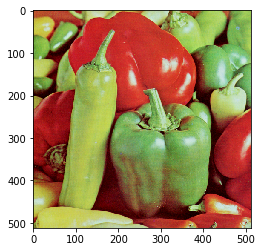

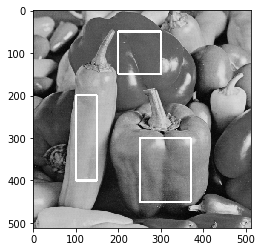

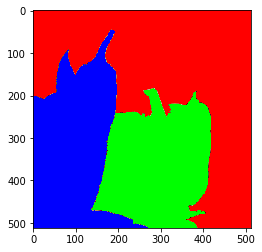

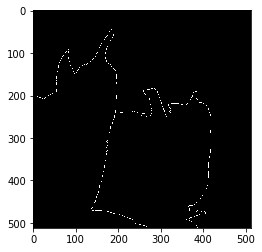

In [70]:
# Watershed
img = cv2.cvtColor(cv2.imread('images/peppers.png'),cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.show()

x11, x12, y11, y12 = 200, 300, 50, 150
x21, x22, y21, y22 = 250, 370, 300, 450
x31, x32, y31, y32 = 100, 150, 200, 400
r1 = np.array([(x11,y11), (x12,y11), (x12,y12), (x11,y12)])
r2 = np.array([(x21,y21), (x22,y21), (x22,y22), (x21,y22)])
r3 = np.array([(x31,y31), (x32,y31), (x32,y32), (x31,y32)])
img2 = img.copy()
cv2.polylines(img2,[r1,r2, r3],True,(255,255,255),3)
plt.imshow(cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY),'gray'); plt.show()

markers = np.int32(np.zeros((img.shape[0], img.shape[1])))
markers[y11:y12,x11:x12] = 1
markers[y21:y22,x21:x22] = 2
markers[y31:y32,x31:x32] = 3

markers = cv2.watershed(img,markers)
img[markers == 1] = [255,0,0]
img[markers == 2] = [0,255,0]
img[markers == 3] = [0,0,255]
plt.imshow(img); plt.show()
plt.imshow(markers == -1,'gray'); plt.show()

## Corte normalizado (complemento - Szeliski)

Unfortunately, computing the optimal normalized cut is NP-complete. Instead, Shi and Malik (2000) suggest computing a real-valued assignment of nodes to groups. Let x be the indicator vector where $x_i = +1$ iff $i \in A$ and $x_i = −1$ iff $i \in B$. Let $d = W \cdot \mathbf{1}$ be the row sums of the symmetric matrix W and $D = \text{diag}(d)$ be the corresponding diagonal matrix.
Shi and Malik (2000) show that minimizing the normalized cut over all possible indicator vectors x is equivalent to minimizing
$$\min_y \frac{y^T (D − W )y}{y^T Dy}$$
where $y = ((1 + x) − b(1 − x))/2$ is a vector consisting of all 1s and −bs such that $y \cdot d = 0$.
Minimizing this Rayleigh quotient is equivalent to solving the generalized eigenvalue system
$$(D − W )y = λDy,$$
which can be turned into a regular eigenvalue problem
$$(I − N )z = λz,$$
where $N = D^{−1/2} W D^{−1/2}$ is the normalized affinity matrix (Weiss 1999) and $z =
D^{1/2} y$.

# GrabCut (segmentação por corte em grafos) [OpenCV]
https://docs.opencv.org/trunk/d8/d83/tutorial_py_grabcut.html

- User inputs the rectangle. Everything outside this rectangle will be taken as sure background (That is the reason it is mentioned before that your rectangle should include all the objects). Everything inside rectangle is unknown. Similarly any user input specifying foreground and background are considered as hard-labelling which means they won't change in the process.
- Computer does an initial labelling depending on the data we gave. It labels the foreground and background pixels (or it hard-labels)
- Now a __Gaussian Mixture Model(GMM) is used to model the foreground and background.__
- Depending on the data we gave, GMM learns and create new pixel distribution. That is, the unknown pixels are labelled either probable foreground or probable background depending on its relation with the other hard-labelled pixels in terms of color statistics (It is just like clustering).
- A graph is built from this pixel distribution. __Nodes in the graphs are pixels.__ Additional two nodes are __added, Source node and Sink node. Every foreground pixel is connected to Source node and every background pixel is connected to Sink node.__
- The __weights of edges connecting pixels to source node/end node__ are defined by the __probability of a pixel being foreground/background.__ The __weights between the pixels__ are defined by the edge information or __pixel similarity.__ If there is a large difference in pixel color, the edge between them will get a low weight.
- Then a __mincut algorithm__ is used to segment the graph. It cuts the graph into two separating source node and sink node with minimum cost function. The cost function is the sum of all weights of the edges that are cut. After the cut, all the pixels connected to Source node become foreground and those connected to Sink node become background.
- The process is continued until the classification converges.

Código mincut em python disponibilizado pelo Google: https://developers.google.com/optimization/flow/maxflow

<img src="images/teoria/grabcut.jpg" width=800>

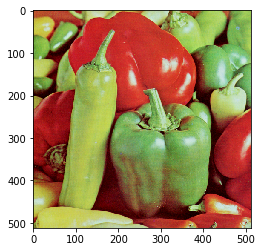

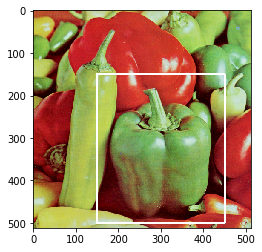

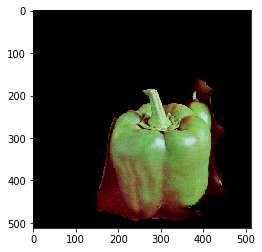

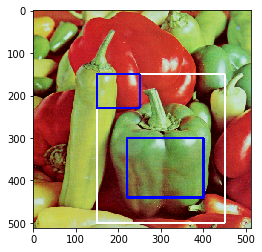

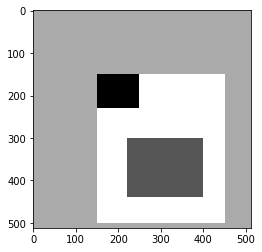

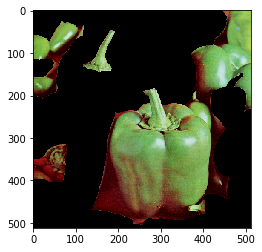

In [68]:
#cv2.grabCut()
#-img - Input image
#-mask - It is a mask image where we specify which areas are background, foreground or probable background/foreground etc. It is done by the following flags, cv.GC_BGD, cv.GC_FGD, cv.GC_PR_BGD, cv.GC_PR_FGD, or simply pass 0,1,2,3 to image.
#-rect - It is the coordinates of a rectangle which includes the foreground object in the format (x,y,w,h)
#-bdgModel, fgdModel - These are arrays used by the algorithm internally. You just create two np.float64 type zero arrays of size (1,65).
#-iterCount - Number of iterations the algorithm should run.
#-mode - It should be cv.GC_INIT_WITH_RECT or cv.GC_INIT_WITH_MASK or combined which decides whether we are drawing rectangle or final touchup strokes.

img = cv2.cvtColor(cv2.imread('images/peppers.png'),cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.show()

# Usando apenas o retângulo que separa o objeto do fundo
x11, x12, y11, y12 = 150, 450, 150, 500
r1 = np.array([(x11,y11), (x12,y11), (x12,y12), (x11,y12)])
img2 = img.copy()
cv2.polylines(img2,[r1],True,(255,255,255),3)
plt.imshow(img2); plt.show()

mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (x11, y11, x12-x11, y12-y11)

img3 = img.copy()
cv2.grabCut(img3,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8') # BG "provável"(2) unido a BG "garantido"(0)
img3 = img3*mask2[:,:,np.newaxis]
plt.imshow(img3); plt.show()

# Utilizando uma máscara arbitrária com pontos de background e foreground (garantidos e prováveis)
x21, x22, y21, y22 = 150, 250, 150, 230 # região de BG garantido
x31, x32, y31, y32 = 220, 400, 300, 440 # região de FG garantido
r2 = np.array([(x21,y21), (x22,y21), (x22,y22), (x21,y22)])
r3 = np.array([(x31,y31), (x32,y31), (x32,y32), (x31,y32)])
cv2.polylines(img2,[r2,r3],True,(0,0,255),3)
plt.imshow(img2); plt.show()

mask = np.ones(img.shape[:2],np.uint8) * 2 # BG provável (default)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
mask[y11:y12, x11:x12] = 3 # FG provável (dentro do retângulo inicial)
mask[y21:y22, x21:x22] = 0 # BG sure
mask[y31:y32, x31:x32] = 1 # FG sure
plt.imshow(mask,'gray'); plt.show()

mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask[:,:,np.newaxis]
plt.imshow(img); plt.show()

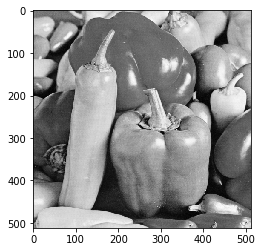

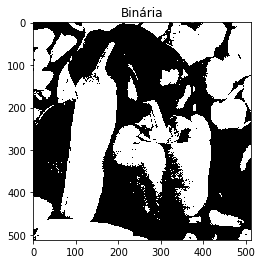

[[0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0]]


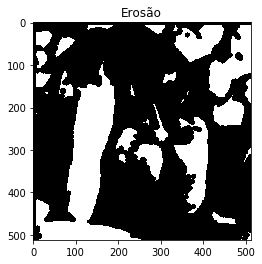

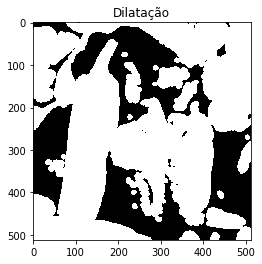

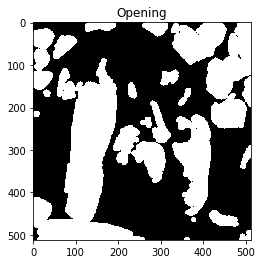

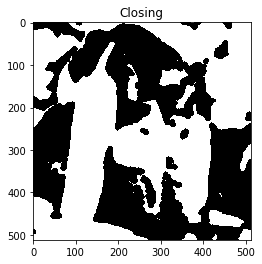

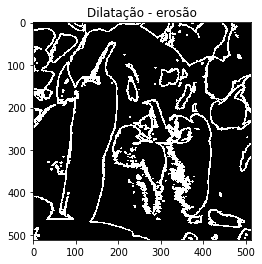

In [4]:
# Operações morfológicas
# http://homepages.inf.ed.ac.uk/rbf/HIPR2/morops.htm

img = cv2.imread('images/peppers.png',0)
plt.imshow(img,'gray'); plt.show()

ret,binaria = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
plt.imshow(binaria,'gray'); plt.title('Binária'); plt.show()

#kernel = np.ones((15,15),np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13))
print(kernel)

plt.imshow(cv2.erode(binaria,kernel,iterations=1),'gray'); plt.title('Erosão'); plt.show()
plt.imshow(cv2.dilate(binaria,kernel,iterations=1),'gray'); plt.title('Dilatação'); plt.show()
plt.imshow(cv2.morphologyEx(binaria, cv2.MORPH_OPEN, kernel),'gray'); plt.title('Opening'); plt.show()
plt.imshow(cv2.morphologyEx(binaria, cv2.MORPH_CLOSE, kernel),'gray'); plt.title('Closing'); plt.show()
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
plt.imshow(cv2.morphologyEx(binaria, cv2.MORPH_GRADIENT, kernel),'gray'); plt.title('Dilatação - erosão'); plt.show()

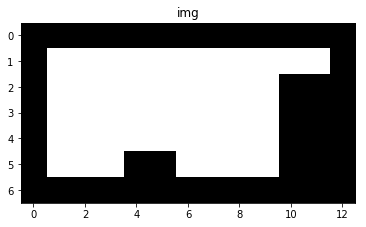

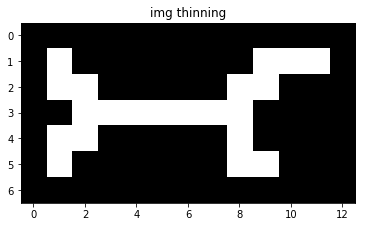

In [13]:
# Thinning
def thinning(img, niter=8, verbose=False):
    k = np.array([[[-1,-1,-1],[0,1,0],[1,1,1]], # kernels do slide 45
                  [[0,-1,-1],[1,1,-1],[1,1,0]], # -1 background, 1 foreground, 0 ignorado.
                  [[1,0,-1],[1,1,-1],[1,0,-1]],
                  [[1,1,0],[1,1,-1],[0,-1,-1]],
                  [[1,1,1],[0,1,0],[-1,-1,-1]],
                  [[0,1,1],[-1,1,1],[-1,-1,0]],
                  [[-1,0,1],[-1,1,1],[-1,0,1]],
                  [[-1,-1,0],[-1,1,1],[0,1,1]]])      
    for i in range(niter):
        m = cv2.morphologyEx(img, cv2.MORPH_HITMISS, k[i % 8])
        img = img * (1 - m) # thinning = img inter (complemento do hit-and-miss)
        if verbose:
            plt.imshow(k[i % 8],'gray'); plt.show()
            plt.imshow(img,'gray'); plt.show()
    return img

img = np.ones((7,13), np.uint8); img[5,4:6] = 0; img[2:6,10:12] = 0; img[0,:]=img[:,0]=img[:,-1]=img[-1,:]=0
plt.imshow(img,'gray'); plt.title('img'); plt.show()
imgt = thinning(img,16,False)
plt.imshow(imgt,'gray'); plt.title('img thinning'); plt.show()